# Create Potential SNIIP List

Author: Melissa Graham & Midori Rollins

Identify potential type IIP supernovae from the "good" candidates created for all of the DDF.

To do this, we constrain the time spans, peak magnitudes, amplitudes, # of detections, decline slopes and decline times

Write the list of potential SNIIP to `potential_sniip_list.txt`.

Save the plot of every potential SNIIP lightcurve in the folder `all_potential_sniip_plots/`.

## Set up and read in data

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import datetime
from astropy.time import Time

Last run.

In [2]:
print(datetime.datetime.now())

2024-08-24 18:10:04.533402


Colors to use for COSMOS-g, -r, -i and ELAIS-g, -r, -i

In [3]:
clr = ['darkgreen', 'firebrick', 'saddlebrown', 'limegreen', 'orange', 'lightcoral']

all_filters = ['g','r','i']
all_fcolors = ['green','red','blue']
all_fshapes = ['o','s','^']
all_fsizes  = [5, 5, 7]

Candidate light curves.

In [4]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'

candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))

del fnm

Candidate light curve parameters.

In [5]:
fnm = '../all_nightly_epochs_files/candidate_lightcurve_parameters.dat'

paramLC_field = np.loadtxt( fnm, dtype='str', usecols=(0) )
paramLC_candid = np.loadtxt( fnm, dtype='str', usecols=(1) )
paramLC_tspan = np.loadtxt( fnm, dtype='float', usecols=(2) )
paramLC_tspan_g = np.loadtxt( fnm, dtype='float', usecols=(3) )
paramLC_tspan_r = np.loadtxt( fnm, dtype='float', usecols=(4) )
paramLC_tspan_i = np.loadtxt( fnm, dtype='float', usecols=(5) )
paramLC_minmag = np.loadtxt( fnm, dtype='float', usecols=(6) )
paramLC_minmag_g = np.loadtxt( fnm, dtype='float', usecols=(7) )
paramLC_minmag_r = np.loadtxt( fnm, dtype='float', usecols=(8) )
paramLC_minmag_i = np.loadtxt( fnm, dtype='float', usecols=(9) )
paramLC_amp = np.loadtxt( fnm, dtype='float', usecols=(10) )
paramLC_amp_g = np.loadtxt( fnm, dtype='float', usecols=(11) )
paramLC_amp_r = np.loadtxt( fnm, dtype='float', usecols=(12) )
paramLC_amp_i = np.loadtxt( fnm, dtype='float', usecols=(13) )
paramLC_neps = np.loadtxt( fnm, dtype='int', usecols=(14) )
paramLC_neps_g = np.loadtxt( fnm, dtype='int', usecols=(15) )
paramLC_neps_r = np.loadtxt( fnm, dtype='int', usecols=(16) )
paramLC_neps_i = np.loadtxt( fnm, dtype='int', usecols=(17) )

del fnm

## Identify potential SNe IIP

After reaching peak magnitude, SNIIP tend to remain a relatively consistent brightness for ~100 days before declining. 

### Apply rough cuts on time span

See how many candidates have light curve time spans of 50 to 100 days in each band, any band, and all three bands.

In [6]:
tx = np.where((paramLC_tspan > 50) & (paramLC_tspan < 150))[0]
gtx = np.where((paramLC_tspan_g > 50) & (paramLC_tspan_g < 150))[0]
rtx = np.where((paramLC_tspan_r > 50) & (paramLC_tspan_r < 150))[0]
itx = np.where((paramLC_tspan_i > 50) & (paramLC_tspan_i < 150))[0]
gritx = np.where((paramLC_tspan_g > 50) & (paramLC_tspan_g < 150) & 
                 (paramLC_tspan_r > 50) & (paramLC_tspan_r < 150) & 
                 (paramLC_tspan_i > 50) & (paramLC_tspan_i < 150))[0]
print('any ', len(tx))
print('g   ', len(gtx))
print('r   ', len(rtx))
print('i   ', len(itx))
print('all ', len(gritx))
del tx, gtx, rtx, itx, gritx

any  250
g    207
r    243
i    241
all  70


### Identify and characterize potential 'plateau' phases

See how many candidates have a 'plateau'-like feature.

Calculate a slope in each band during the time when, if the candidate is SNIIP-like, it would be in the plateau phase.

Use only the observations after the first 15 days (in case the rise was caught) and up to 80 days (to miss the decline).

Only do this for candidates with r-band light curve time spans between 50 and 100 days (but calculate slopes in all filters).

In [7]:
%%time
showplots = False

# date of first detection
paramLC_t0_g = np.zeros(len(paramLC_candid), dtype='float')
paramLC_t0_r = np.zeros(len(paramLC_candid), dtype='float')
paramLC_t0_i = np.zeros(len(paramLC_candid), dtype='float')
# potential "plateau"-phase time-span
paramLC_pspan_g = np.zeros(len(paramLC_candid), dtype='float')
paramLC_pspan_r = np.zeros(len(paramLC_candid), dtype='float')
paramLC_pspan_i = np.zeros(len(paramLC_candid), dtype='float')
# potential "plateau"-phase number of epochs
paramLC_pneps_g = np.zeros(len(paramLC_candid), dtype='float')
paramLC_pneps_r = np.zeros(len(paramLC_candid), dtype='float')
paramLC_pneps_i = np.zeros(len(paramLC_candid), dtype='float')
# potential "plateau"-phase slope
paramLC_pslope_g = np.zeros(len(paramLC_candid), dtype='float') - 99.9
paramLC_pslope_r = np.zeros(len(paramLC_candid), dtype='float') - 99.9
paramLC_pslope_i = np.zeros(len(paramLC_candid), dtype='float') - 99.9
# potential "plateau"-phase yint
paramLC_pyint_g = np.zeros(len(paramLC_candid), dtype='float') - 99.9
paramLC_pyint_r = np.zeros(len(paramLC_candid), dtype='float') - 99.9
paramLC_pyint_i = np.zeros(len(paramLC_candid), dtype='float') - 99.9


rtx = np.where((paramLC_tspan_r > 50) & (paramLC_tspan_r < 150))[0]
for x in rtx:
    gfit = np.zeros(2, dtype='float') - 99.9
    rfit = np.zeros(2, dtype='float') - 99.9
    ifit = np.zeros(2, dtype='float') - 99.9
    
    gcx = np.where((candLC_candid == paramLC_candid[x]) & (candLC_filter == 'g') & (candLC_lef == 0))[0]
    if len(gcx) > 0:
        paramLC_t0_g[x] = np.min(candLC_mjd[gcx])
        tgcx = np.where((candLC_mjd[gcx] > paramLC_t0_g[x] + 15) & (candLC_mjd[gcx] < paramLC_t0_g[x] + 80))[0]
        if len(tgcx) > 1:
            paramLC_pspan_g[x] = np.max(candLC_mjd[gcx[tgcx]]) - np.min(candLC_mjd[gcx[tgcx]])
            paramLC_pneps_g[x] = len(tgcx)
            gdays = candLC_mjd[gcx[tgcx]]
            gmags = candLC_mag[gcx[tgcx]]
            gfit = np.polyfit(gdays, gmags, 1)
            paramLC_pslope_g[x] = gfit[0]
            paramLC_pyint_g[x] = gfit[1]

    rcx = np.where((candLC_candid == paramLC_candid[x]) & (candLC_filter == 'r') & (candLC_lef == 0))[0]
    if len(rcx) > 0:
        paramLC_t0_r[x] = np.min(candLC_mjd[rcx])
        trcx = np.where((candLC_mjd[rcx] > paramLC_t0_r[x] + 15) & (candLC_mjd[rcx] < paramLC_t0_r[x] + 80))[0]
        if len(trcx) > 1:
            paramLC_pspan_r[x] = np.max(candLC_mjd[rcx[trcx]]) - np.min(candLC_mjd[rcx[trcx]])
            paramLC_pneps_r[x] = len(trcx)
            rdays = candLC_mjd[rcx[trcx]]
            rmags = candLC_mag[rcx[trcx]]
            rfit = np.polyfit(rdays, rmags, 1)
            paramLC_pslope_r[x] = rfit[0]
            paramLC_pyint_r[x] = rfit[1]

    icx = np.where((candLC_candid == paramLC_candid[x]) & (candLC_filter == 'i') & (candLC_lef == 0))[0]
    if len(icx) > 0:
        paramLC_t0_i[x] = np.min(candLC_mjd[icx])
        ticx = np.where((candLC_mjd[icx] > paramLC_t0_i[x] + 15) & (candLC_mjd[icx] < paramLC_t0_i[x] + 80))[0]
        if len(ticx) > 1:
            paramLC_pspan_i[x] = np.max(candLC_mjd[icx[ticx]]) - np.min(candLC_mjd[icx[ticx]])
            paramLC_pneps_i[x] = len(ticx)
            idays = candLC_mjd[icx[ticx]]
            imags = candLC_mag[icx[ticx]]
            ifit = np.polyfit(idays, imags, 1)
            paramLC_pslope_i[x] = ifit[0]
            paramLC_pyint_i[x] = ifit[1]

    if showplots:
        fig = plt.figure(figsize=(6, 2))
        if len(gcx) > 0:
            plt.plot(candLC_mjd[gcx], candLC_mag[gcx], all_fshapes[0], ms=3, alpha=0.4, mew=0, color=all_fcolors[0])
            if len(tgcx) > 1:
                plt.plot(gdays, gmags, all_fshapes[0], ms=5, alpha=0.5, mew=0, color=all_fcolors[0])
                if gfit[0] > -99.:
                    gfitvals = gfit[1] + gfit[0]*gdays
                    plt.plot(gdays, gfitvals, ls='solid', color=all_fcolors[0])
                    del gfitvals, gfit
                del gdays, gmags, tgcx
        if len(rcx) > 0:
            plt.plot(candLC_mjd[rcx], candLC_mag[rcx], all_fshapes[1], ms=3, alpha=0.4, mew=0, color=all_fcolors[1])
            if len(trcx) > 1:
                plt.plot(rdays, rmags, all_fshapes[1], ms=5, alpha=0.5, mew=0, color=all_fcolors[1])
                if rfit[0] > -99.:
                    rfitvals = rfit[1] + rfit[0]*rdays
                    plt.plot(rdays, rfitvals, ls='solid', color=all_fcolors[1])
                    print(rfit[0])
                    del rfitvals, rfit
                del rdays, rmags, trcx
        if len(icx) > 0:
            plt.plot(candLC_mjd[icx], candLC_mag[icx], all_fshapes[2], ms=3, alpha=0.4, mew=0, color=all_fcolors[2])
            if len(ticx) > 1:
                plt.plot(idays, imags, all_fshapes[2], ms=5, alpha=0.5, mew=0, color=all_fcolors[2])
                if ifit[0] > -99.:
                    ifitvals = ifit[1] + ifit[0]*idays
                    plt.plot(idays, ifitvals, ls='solid', color=all_fcolors[2])
                    del ifitvals, ifit
                del idays, imags, ticx
        ymax = np.max([np.max(candLC_mag[gcx]), np.max(candLC_mag[rcx]), np.max(candLC_mag[icx])])
        ymin = paramLC_minmag[x]
        plt.ylim([ymax+0.1, ymin-0.1])
        plt.title(paramLC_candid[x])
        plt.show()
        del ymax, ymin
        
    del gcx, rcx, icx

CPU times: user 547 ms, sys: 27 ms, total: 574 ms
Wall time: 735 ms


Histogram of 'plateau'-phase slopes.

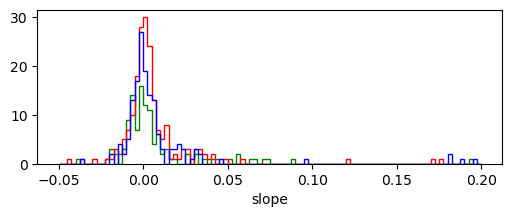

In [8]:
fig = plt.figure(figsize=(6, 2))
gx = np.where(paramLC_pslope_g > -99)[0]
rx = np.where(paramLC_pslope_r > -99)[0]
ix = np.where(paramLC_pslope_i > -99)[0]
plt.hist(paramLC_pslope_g[gx], bins=100, range=(-0.05, 0.20), histtype='step', color=all_fcolors[0])
plt.hist(paramLC_pslope_r[rx], bins=100, range=(-0.05, 0.20), histtype='step', color=all_fcolors[1])
plt.hist(paramLC_pslope_i[ix], bins=100, range=(-0.05, 0.20), histtype='step', color=all_fcolors[2])
plt.xlabel('slope')
plt.show()
del gx, rx, ix

Histogram of 'plateau'-phase time spans.

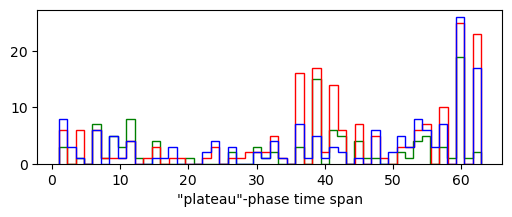

In [9]:
fig = plt.figure(figsize=(6, 2))
gx = np.where(paramLC_pspan_g > 0.)[0]
rx = np.where(paramLC_pspan_r > 0.)[0]
ix = np.where(paramLC_pspan_i > 0.)[0]
plt.hist(paramLC_pspan_g[gx], bins=50, histtype='step', color=all_fcolors[0])
plt.hist(paramLC_pspan_r[rx], bins=50, histtype='step', color=all_fcolors[1])
plt.hist(paramLC_pspan_i[ix], bins=50, histtype='step', color=all_fcolors[2])
plt.xlabel('"plateau"-phase time span')
plt.show()
del gx, rx, ix

Histogram of 'plateau'-phase number of epochs.

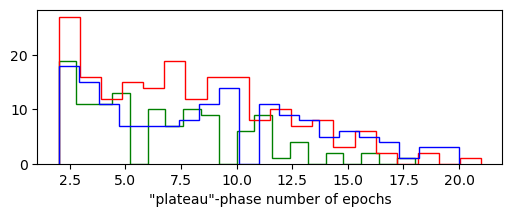

In [10]:
fig = plt.figure(figsize=(6, 2))
gx = np.where(paramLC_pneps_g > 0.)[0]
rx = np.where(paramLC_pneps_r > 0.)[0]
ix = np.where(paramLC_pneps_i > 0.)[0]
plt.hist(paramLC_pneps_g[gx], bins=20, histtype='step', color=all_fcolors[0])
plt.hist(paramLC_pneps_r[rx], bins=20, histtype='step', color=all_fcolors[1])
plt.hist(paramLC_pneps_i[ix], bins=20, histtype='step', color=all_fcolors[2])
plt.xlabel('"plateau"-phase number of epochs')
plt.show()
del gx, rx, ix

Number of candidates with:
 * r-band time spans 50 to 100 days
 * declining potential "plateau"-phase slopes of < 0.03 mag/day
 * duration of potential "plateau"-phase at least 40 days
 * number of epochs during potential "plateau"-phase at least 10 epochs

In [11]:
gx = np.where((paramLC_pslope_g > 0.0) & (paramLC_pslope_g < 0.03) & (paramLC_pspan_g > 40) & (paramLC_pneps_g > 7))[0]
rx = np.where((paramLC_pslope_r > 0.0) & (paramLC_pslope_r < 0.03) & (paramLC_pspan_r > 40) & (paramLC_pneps_r > 7))[0]
ix = np.where((paramLC_pslope_i > 0.0) & (paramLC_pslope_i < 0.03) & (paramLC_pspan_i > 40) & (paramLC_pneps_i > 7))[0]
print(len(gx), len(rx), len(ix))
del gx, rx, ix

15 42 30


### Review light curves of best candidates

Plot the light curves for the 21 candidates identified by r-band.

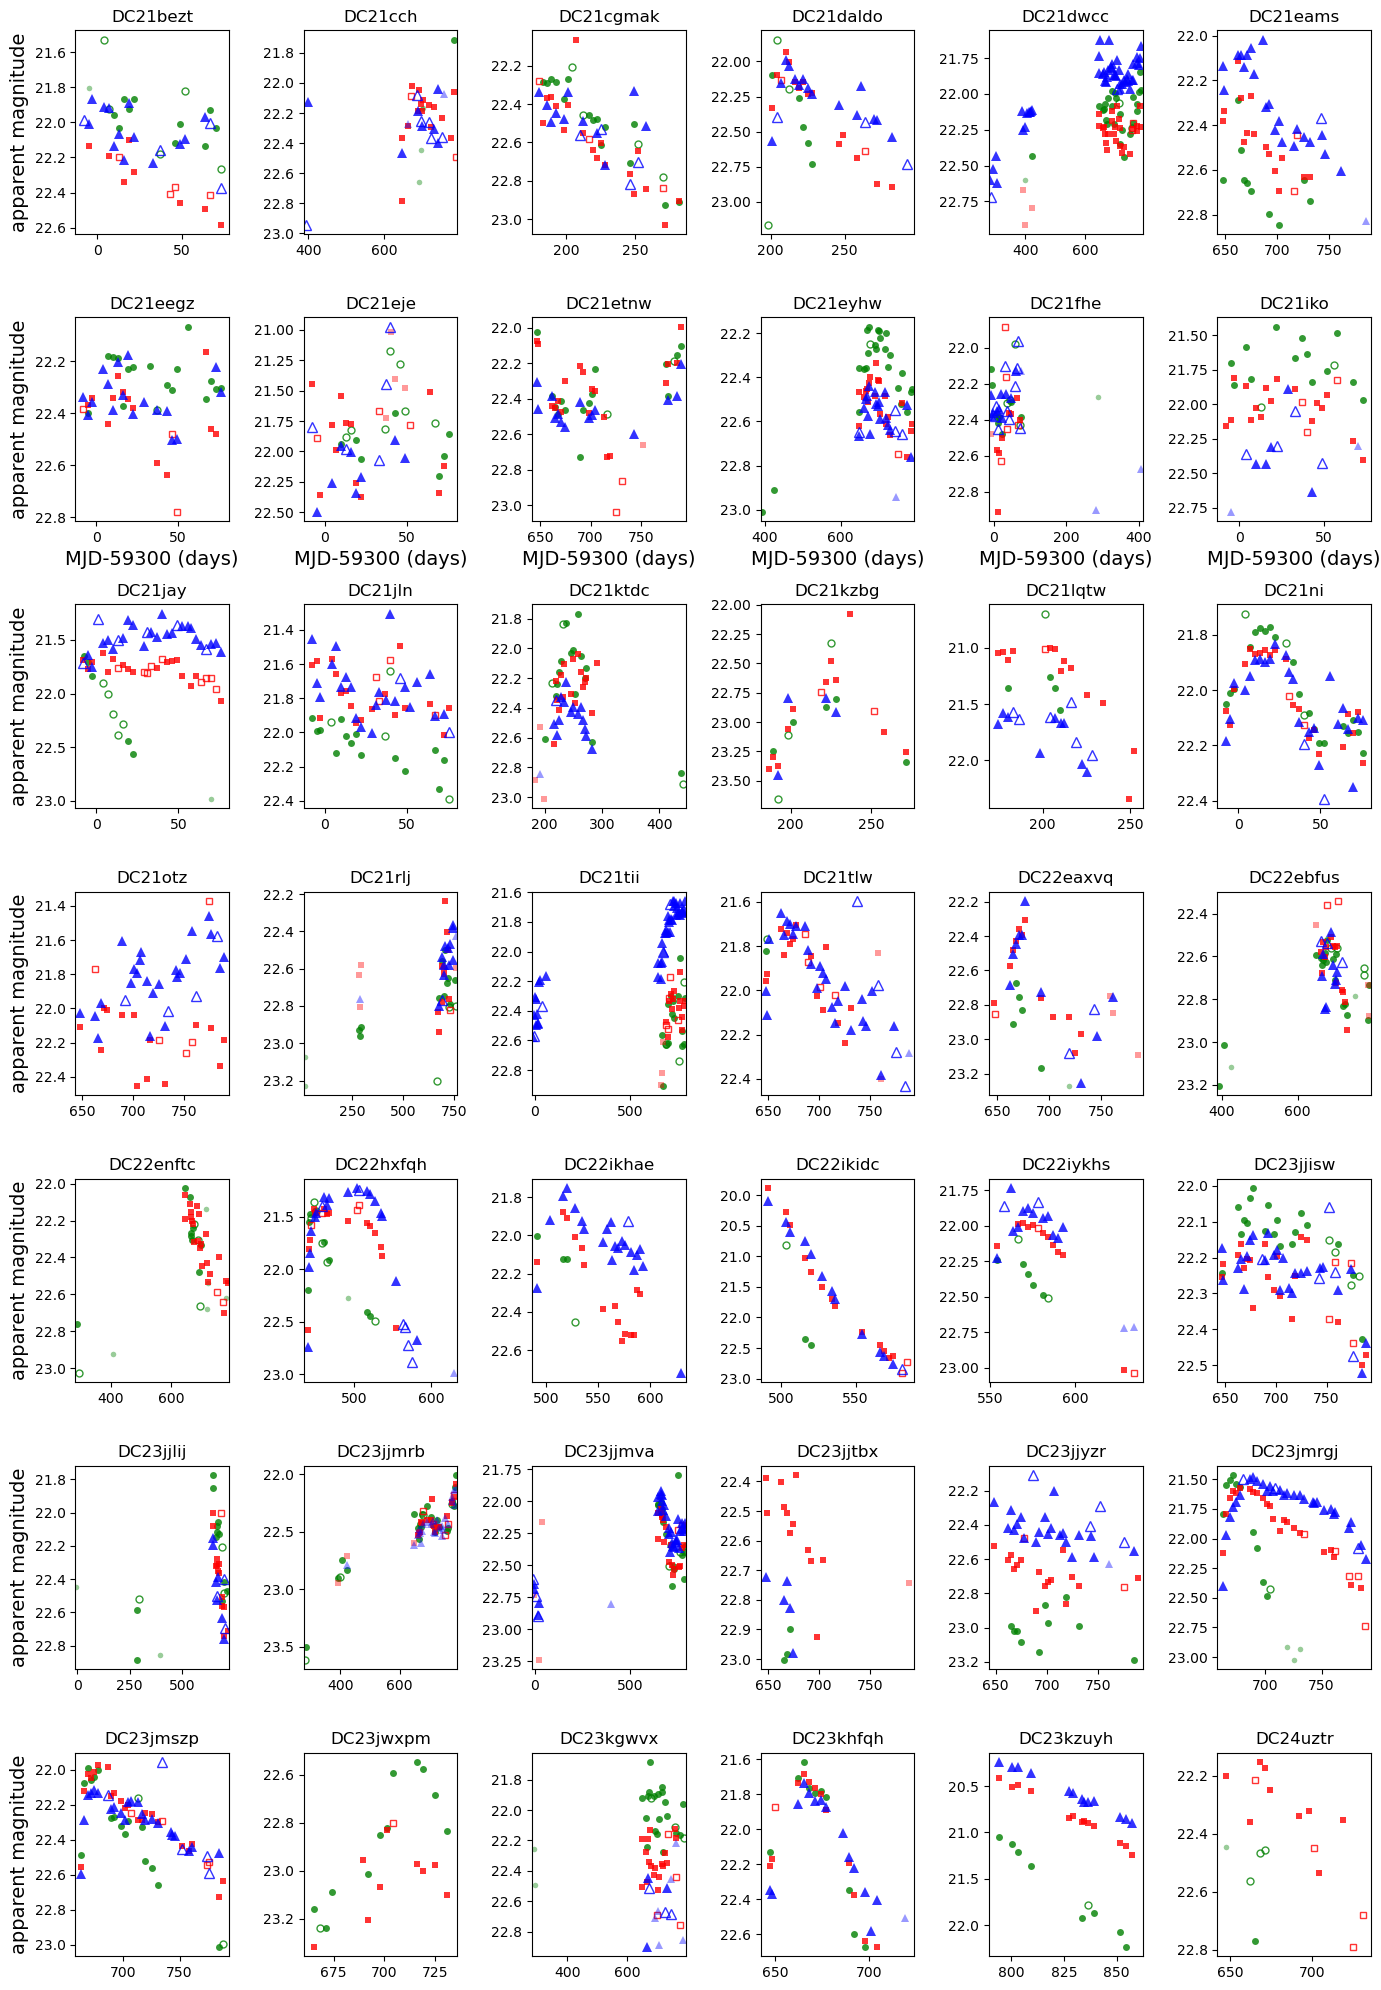

In [12]:
rx = np.where((paramLC_pslope_r > 0.0) & (paramLC_pslope_r < 0.03) & (paramLC_pspan_r > 40) & (paramLC_pneps_r > 7))[0]

nrow = 7
ncol = 6
fig, ax = plt.subplots( nrow, ncol, figsize=(14, 20), sharex=False, sharey=False )

x = 0
for i in range(nrow):
    ax[i, 0].set_ylabel('apparent magnitude', fontsize=14)
    for j in range(ncol):
        for f,filt in enumerate(all_filters):
            cx0 = np.where((candLC_candid == paramLC_candid[rx[x]]) & \
                           (candLC_filter == filt) & (candLC_mrb > 0.4))[0]
            cx1 = np.where((candLC_candid == paramLC_candid[rx[x]]) & \
                           (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 0))[0]
            cx2 = np.where((candLC_candid == paramLC_candid[rx[x]]) & \
                           (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 1))[0]
            ax[i, j].plot(candLC_mjd[cx0]-59300., candLC_mag[cx0], 
                         all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
            ax[i, j].plot(candLC_mjd[cx1]-59300., candLC_mag[cx1], 
                         all_fshapes[f], ms=all_fsizes[f], mew=1, alpha=0.8, color='none', mec=all_fcolors[f])
            ax[i, j].plot(candLC_mjd[cx2]-59300., candLC_mag[cx2], 
                         all_fshapes[f], ms=all_fsizes[f]-1, mew=0, alpha=0.4, color=all_fcolors[f])
        cx = np.where(candLC_candid == paramLC_candid[rx[x]])[0]
        xmin = np.min(candLC_mjd[cx])
        xmax = np.max(candLC_mjd[cx])
        ax[i, j].invert_yaxis()
        ax[i, j].set_xlim([xmin-59300.-5, xmax-59300.+5])
        del xmin, xmax
        ax[i, j].set_title(paramLC_candid[rx[x]])
        x += 1
            
# ax[0, 1].legend(loc='upper right', labelspacing=0.1, handletextpad=0.1, fontsize=14)
for j in range(ncol):
    ax[1, j].set_xlabel('MJD-59300 (days)', fontsize=14)

plt.tight_layout()
plt.show()
del rx, x

There are three of the above that look like clear potential SNIIP:
 * DC21daldo
 * DC21jay
 * DC22hxfqh
 * DC22iykhs
 * DC23jmrgj
 * DC23jmszp
 * DC23kzuyh
 
### Write to file


In [13]:
psniip_list = np.asarray(['DC21daldo', 'DC21jay', 'DC22hxfqh', 'DC22iykhs', 'DC23jmrgj', 'DC23jmszp', 'DC23kzuyh'], dtype='str')
fout = open('potential_sniip_list.dat', 'w')
fout.write('# Melissa Graham, 1_find_potential_sniip.ipynb \n')
fout.write('# UTC = ' + str(datetime.datetime.now()) + ' \n')
fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 id       : candidate identifier \n')
fout.write('#  1 t0_g     : MJD of first detection in g \n')
fout.write('#  2 t0_r     : MJD of first detection in r \n')
fout.write('#  3 t0_i     : MJD of first detection in i \n')
fout.write('#  4 pspan_g  : time span of potential plateau used for slope in g \n')
fout.write('#  5 pspan_r  : time span of potential plateau used for slope in r \n')
fout.write('#  6 pspan_i  : time span of potential plateau used for slope in i \n')
fout.write('#  7 pneps_g  : number of epochs during potential plateau used for slope in g \n')
fout.write('#  8 pneps_r  : number of epochs during potential plateau used for slope in r \n')
fout.write('#  9 pneps_i  : number of epochs during potential plateau used for slope in i \n')
fout.write('# 10 pslope_g : slope fit to potential plateau in g \n')
fout.write('# 11 pslope_r : slope fit to potential plateau in r \n')
fout.write('# 12 pslope_i : slope fit to potential plateau in i \n')
fout.write('# 13 pyint_g  : yinit fit to potential plateau in g \n')
fout.write('# 14 pyint_r  : yinit fit to potential plateau in r \n')
fout.write('# 15 pyint_i  : yinit fit to potential plateau in i \n')
fout.write('# \n')
for i in range(len(psniip_list)):
    j = np.where(paramLC_candid == psniip_list[i])[0]
    x = j[0]
    fout.write('%10s ' % paramLC_candid[x])
    fout.write('%8.2f %8.2f %8.2f ' % (paramLC_t0_g[x], paramLC_t0_r[x], paramLC_t0_i[x]))
    fout.write('%6.2f %6.2f %6.2f ' % (paramLC_pspan_g[x], paramLC_pspan_r[x], paramLC_pspan_i[x]))
    fout.write('%3i %3i %3i ' % (paramLC_pneps_g[x], paramLC_pneps_r[x], paramLC_pneps_i[x]))
    fout.write('%.5E %.5E %.5E ' % (paramLC_pslope_g[x], paramLC_pslope_r[x], paramLC_pslope_i[x]))
    fout.write('%.5E %.5E %.5E ' % (paramLC_pyint_g[x], paramLC_pyint_r[x], paramLC_pyint_i[x]))
    fout.write(' \n')
fout.close()

## Create figure for the paper

With light curves and 'plateau' fits.

Include the weird object DC22ikidc.

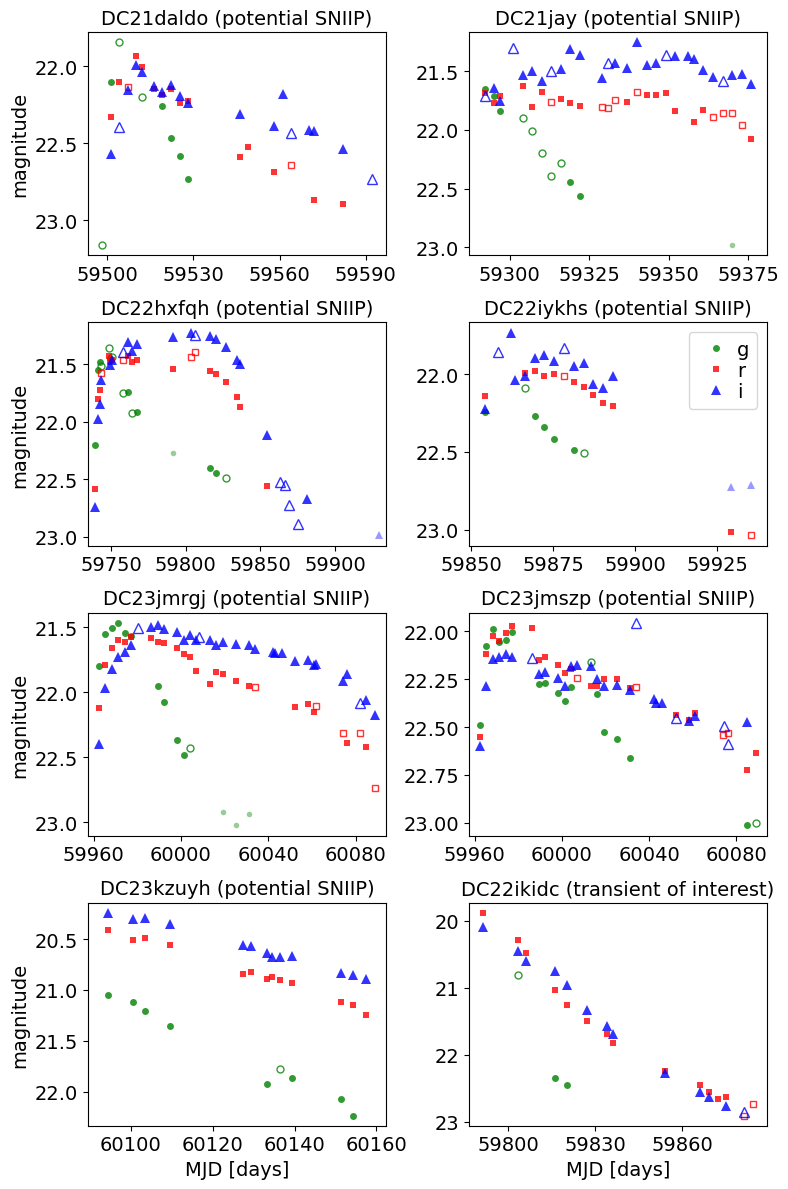

In [27]:
plot_list = np.asarray(['DC21daldo', 'DC21jay', 'DC22hxfqh', 'DC22iykhs', 
                        'DC23jmrgj', 'DC23jmszp', 'DC23kzuyh', 'DC22ikidc'], dtype='str')

nrow = 4
ncol = 2
fig, ax = plt.subplots( nrow, ncol, figsize=(8, 12), sharex=False, sharey=False )

x = 0
for i in range(nrow):
    ax[i, 0].set_ylabel('magnitude', fontsize=14)
    for j in range(ncol):
        candid = plot_list[x]
        for f,filt in enumerate(all_filters):
            cx0 = np.where((candLC_candid == candid) & \
                           (candLC_filter == filt) & (candLC_mrb > 0.4))[0]
            cx1 = np.where((candLC_candid == candid) & \
                           (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 0))[0]
            cx2 = np.where((candLC_candid == candid) & \
                           (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 1))[0]
            ax[i, j].plot(candLC_mjd[cx0], candLC_mag[cx0], 
                         all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
            ax[i, j].plot(candLC_mjd[cx1], candLC_mag[cx1], 
                         all_fshapes[f], ms=all_fsizes[f], mew=1, alpha=0.8, color='none', mec=all_fcolors[f])
            ax[i, j].plot(candLC_mjd[cx2], candLC_mag[cx2], 
                         all_fshapes[f], ms=all_fsizes[f]-1, mew=0, alpha=0.4, color=all_fcolors[f])
            # ax[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))

        cx = np.where(candLC_candid == candid)[0]
        xmin = np.min(candLC_mjd[cx])
        xmax = np.max(candLC_mjd[cx])
        ax[i, j].invert_yaxis()
        ax[i, j].set_xlim([xmin-5, xmax+5])
        del xmin, xmax
        temp = candid + ' (potential SNIIP)'
        if candid == 'DC22ikidc':
            temp = candid + ' (transient of interest)'
        ax[i, j].set_title(temp, fontsize=14)
        del temp
        ax[i, j].xaxis.set_major_locator(plt.MaxNLocator(4))
        x += 1

        ax[i,j].tick_params(axis='both', which='major', labelsize=14)

ax[1, 1].legend(loc='upper right', labelspacing=0.1, handletextpad=0.1, fontsize=14)
for j in range(ncol):
    ax[nrow-1, j].set_xlabel('MJD [days]', fontsize=14)

plt.tight_layout()
plt.savefig('plots/potential_sniip')
plt.show()

### Is DC23jmszp at all like SN2009ip?

Co-plot to see if the "bumpiness" is similar.

In [15]:
fname = 'data_sn2009ip/sn2009ip_photom.dat'
SN09ip_year = np.loadtxt(fname, dtype='int', comments='#', skiprows=38, usecols=(0))
SN09ip_month = np.loadtxt(fname, dtype='int', comments='#', skiprows=38, usecols=(1))
SN09ip_day = np.loadtxt(fname, dtype='int', comments='#', skiprows=38, usecols=(2))
SN09ip_g_2m_mag = np.loadtxt(fname, dtype='float', comments='#', skiprows=38, usecols=(3))
SN09ip_g_2m_mage = np.loadtxt(fname, dtype='float', comments='#', skiprows=38, usecols=(4))
SN09ip_r_2m_mag = np.loadtxt(fname, dtype='float', comments='#', skiprows=38, usecols=(5))
SN09ip_r_2m_mage = np.loadtxt(fname, dtype='float', comments='#', skiprows=38, usecols=(6))
SN09ip_i_2m_mag = np.loadtxt(fname, dtype='float', comments='#', skiprows=38, usecols=(7))
SN09ip_i_2m_mage = np.loadtxt(fname, dtype='float', comments='#', skiprows=38, usecols=(8))

In [16]:
temp = []
for i in range(len(SN09ip_year)):
    s = str(SN09ip_year[i]) + '-' + str(SN09ip_month[i]) + '-' + str(SN09ip_day[i]) + 'T00:00:00'
    t = Time(s, format='isot', scale='utc')
    temp.append(t.mjd)
SN09ip_mjd = np.asarray(temp, dtype='float')

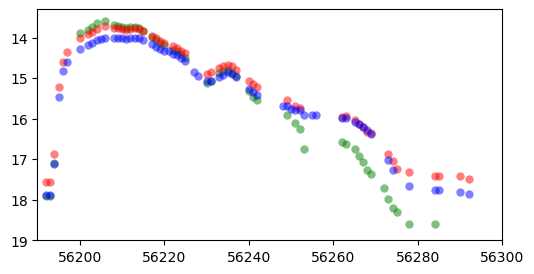

In [17]:
fig = plt.figure(figsize=(6, 3))
tx = np.where(SN09ip_g_2m_mag < 90)[0]
plt.plot(SN09ip_mjd[tx], SN09ip_g_2m_mag[tx], 'o', alpha=0.5, mew=0, color='green')
tx = np.where(SN09ip_r_2m_mag < 90)[0]
plt.plot(SN09ip_mjd[tx], SN09ip_r_2m_mag[tx], 'o', alpha=0.5, mew=0, color='red') 
tx = np.where(SN09ip_i_2m_mag < 90)[0]
plt.plot(SN09ip_mjd[tx], SN09ip_i_2m_mag[tx], 'o', alpha=0.5, mew=0, color='blue')
plt.xlim([56190, 56300])
plt.ylim([19,13.3])
plt.show()

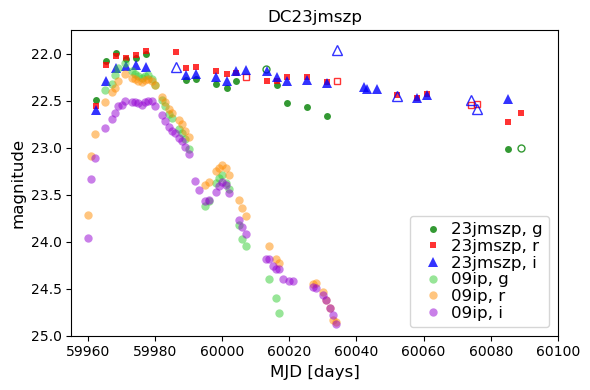

In [18]:
fig = plt.figure(figsize=(6, 4))

candid = 'DC23jmszp'
for f,filt in enumerate(all_filters):
    cx0 = np.where((candLC_candid == candid) & \
                   (candLC_filter == filt) & (candLC_mrb > 0.4))[0]
    cx1 = np.where((candLC_candid == candid) & \
                   (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 0))[0]
    cx2 = np.where((candLC_candid == candid) & \
                   (candLC_filter == filt) & (candLC_mrb <= 0.4) & (candLC_lef == 1))[0]
    plt.plot(candLC_mjd[cx0], candLC_mag[cx0], 
                 all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label='23jmszp, '+filt)
    plt.plot(candLC_mjd[cx1], candLC_mag[cx1], 
                 all_fshapes[f], ms=all_fsizes[f], mew=1, alpha=0.8, color='none', mec=all_fcolors[f])
    plt.plot(candLC_mjd[cx2], candLC_mag[cx2], 
                 all_fshapes[f], ms=all_fsizes[f]-1, mew=0, alpha=0.4, color=all_fcolors[f])

dx = 59955 - 56190
dy = 8.5
tx = np.where(SN09ip_g_2m_mag < 90)[0]
plt.plot(SN09ip_mjd[tx] + dx, SN09ip_g_2m_mag[tx] + dy, 'o', alpha=0.5, mew=0, color='limegreen', label='09ip, g')
tx = np.where(SN09ip_r_2m_mag < 90)[0]
plt.plot(SN09ip_mjd[tx] + dx, SN09ip_r_2m_mag[tx] + dy, 'o', alpha=0.5, mew=0, color='darkorange', label='09ip, r') 
tx = np.where(SN09ip_i_2m_mag < 90)[0]
plt.plot(SN09ip_mjd[tx] + dx, SN09ip_i_2m_mag[tx] + dy, 'o', alpha=0.5, mew=0, color='darkviolet', label='09ip, i')

plt.xlim([59955, 60100])
plt.ylim([25.0, 21.75])
plt.title(candid)
plt.legend(loc='lower right', labelspacing=0.1, handletextpad=0.1, fontsize=12)
plt.xlabel('MJD [days]', fontsize=12)
plt.ylabel('magnitude', fontsize=12)
plt.tight_layout()
# plt.savefig('plots/')
plt.show()